 # Defines

 ## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# show all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)


 ## Data

In [2]:
import pickle

# Load data
with open("output/data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"]
y_train_true = data["y_train_true"]
y_train_compas = data["y_train_compas"]
X_test = data["X_test"]
y_test_true = data["y_test_true"]
y_test_compas = data["y_test_compas"]

# Load model
with open("output/model.pkl", "rb") as f:
    model = pickle.load(f)

# Now you can use X_train, y_train_true, etc. and final_model as needed

In [3]:
protected_features = ["is_black", "is_male", "age"]

In [4]:
# Print the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

print("y_train_compas shape:", y_train_compas.shape)
print("y_test_compas shape:", y_test_compas.shape)

print("y_train_true shape:", y_train_true.shape)
print("y_test_true shape:", y_test_true.shape)

X_train shape: (4937, 9)
X_test shape: (1235, 9)
y_train_compas shape: (4937,)
y_test_compas shape: (1235,)
y_train_true shape: (4937,)
y_test_true shape: (1235,)


 ## Check performance of orignal compas model

In [5]:
# check performance of compas model
print(classification_report(y_true=y_test_true, y_pred=y_test_compas))

              precision    recall  f1-score   support

           0       0.62      0.91      0.74       683
           1       0.74      0.30      0.43       552

    accuracy                           0.64      1235
   macro avg       0.68      0.61      0.58      1235
weighted avg       0.67      0.64      0.60      1235



# Wrap model

In [19]:
X_test.head()

,is_male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,is_felony,is_black
2681,1,26,0,0,0,13,0.0,0,1
2164,1,31,0,1,0,1,0.0,0,0
3875,1,27,0,0,0,2,0.0,1,1
416,1,21,0,0,0,0,0.0,0,0
2030,0,24,0,0,0,1,-1.0,1,0


In [6]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

## Global Importance

In [7]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

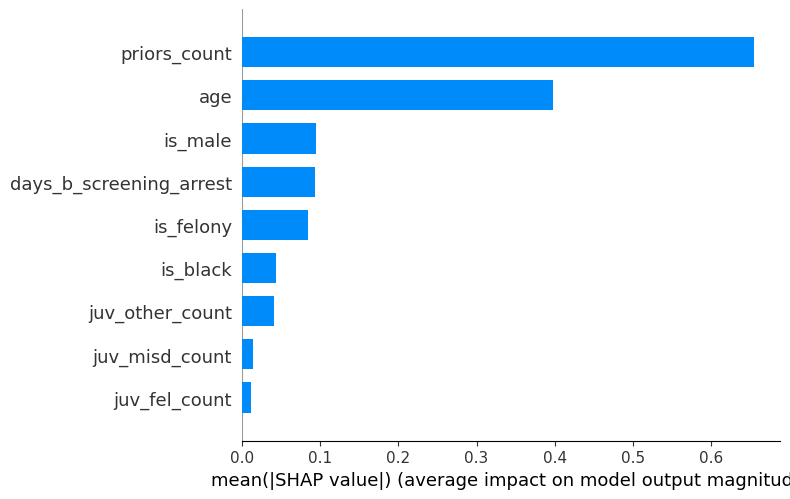

In [8]:
shap.summary_plot(shap_values, X_test, max_display=20, plot_type="bar")

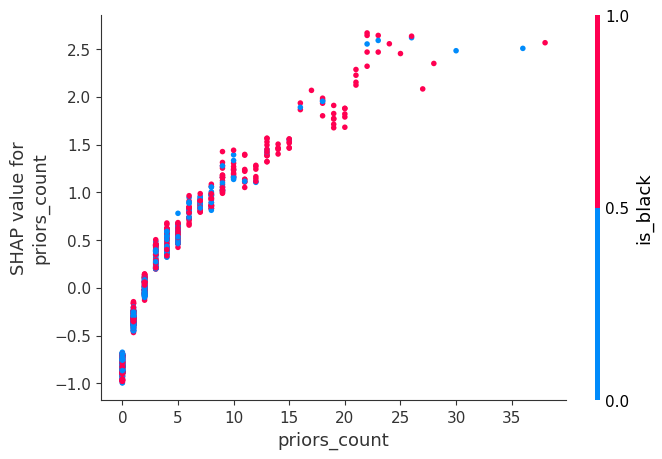

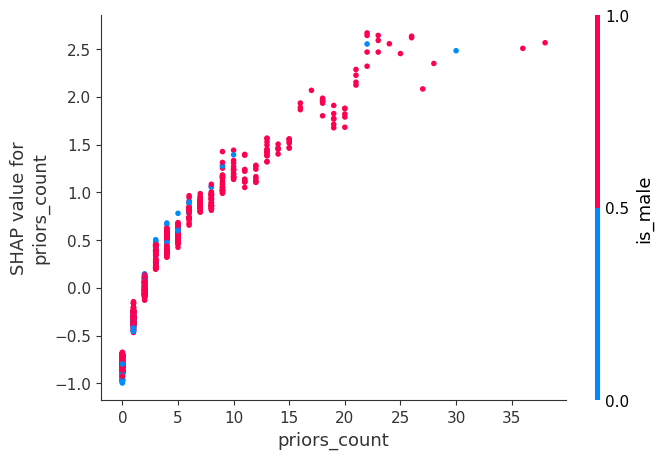

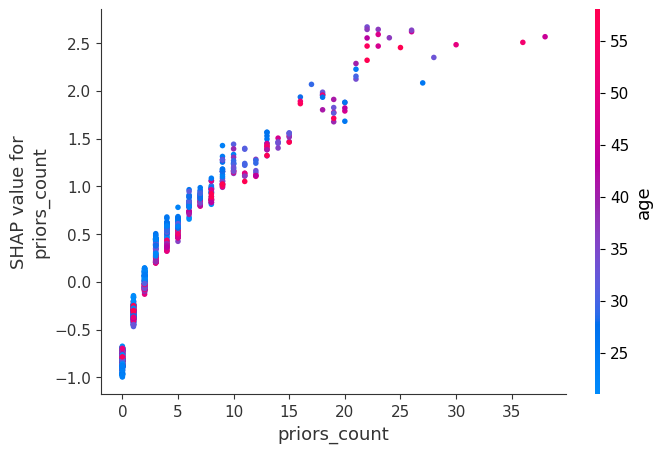

In [9]:
shap.dependence_plot("priors_count", shap_values, X_test, interaction_index="is_black")
shap.dependence_plot("priors_count", shap_values, X_test, interaction_index="is_male")
shap.dependence_plot("priors_count", shap_values, X_test, interaction_index="age")

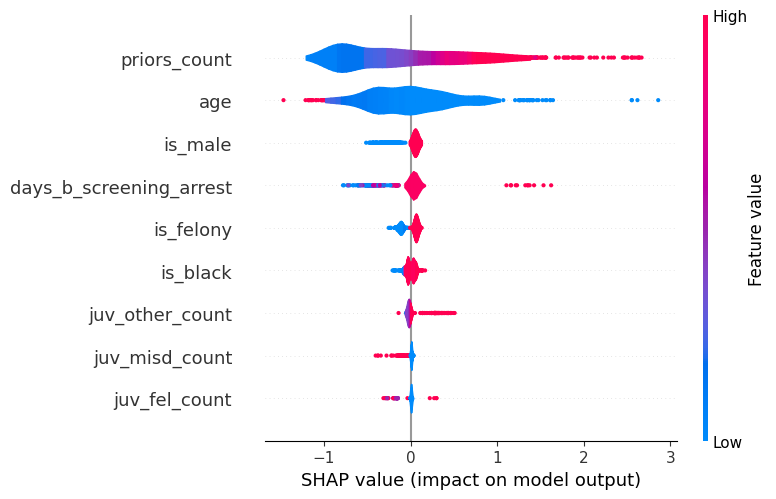

In [10]:
shap.summary_plot(shap_values, X_test, plot_type="violin")

## Calibration Chart

Brief score losses: (the smaller the better)
Base model: 0.2070
Isotonic regression: 0.2084
Logistics regression: 0.2076

Log loss: (the smaller the better)
Base model: 0.6024
Isotonic regression: 0.6884
Logistics regression: 0.6041


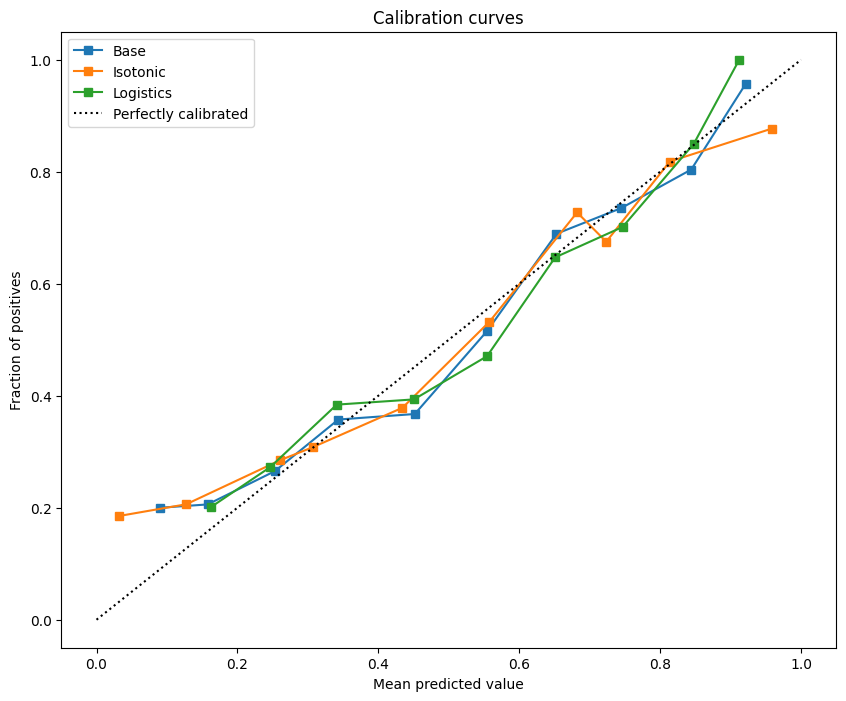

In [11]:
# import sklean CalibratedClassifierCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, log_loss

# Isotonic Regression
iso_clf = CalibratedClassifierCV(model, method="isotonic", cv="prefit")
iso_clf.fit(X_train, y_train_true)
iso_y_pred_proba = iso_clf.predict_proba(X_test)[:, 1]

# Logistics Regression (signmoid)
sig_clf = CalibratedClassifierCV(model, method="sigmoid", cv="prefit")
sig_clf.fit(X_train, y_train_true)
sig_y_pred_proba = sig_clf.predict_proba(X_test)[:, 1]

print("Brief score losses: (the smaller the better)")
base_score = brier_score_loss(y_test_true, y_pred_proba)
iso_score = brier_score_loss(y_test_true, iso_y_pred_proba)
sig_score = brier_score_loss(y_test_true, sig_y_pred_proba)
print(f"Base model: {base_score:.4f}")
print(f"Isotonic regression: {iso_score:.4f}")
print(f"Logistics regression: {sig_score:.4f}")

print("\nLog loss: (the smaller the better)")
based_log_loss = log_loss(y_test_true, y_pred_proba)
iso_log_loss = log_loss(y_test_true, iso_y_pred_proba)
sig_log_loss = log_loss(y_test_true, sig_y_pred_proba)
print(f"Base model: {based_log_loss:.4f}")
print(f"Isotonic regression: {iso_log_loss:.4f}")
print(f"Logistics regression: {sig_log_loss:.4f}")

plt.figure(figsize=(10, 8))
for probs, name in [(y_pred_proba, "Base"), (iso_y_pred_proba, "Isotonic"), (sig_y_pred_proba, "Logistics")]:
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_true, probs, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=name)


plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.legend()
plt.title("Calibration curves")
plt.show()

# Confusion Matrix

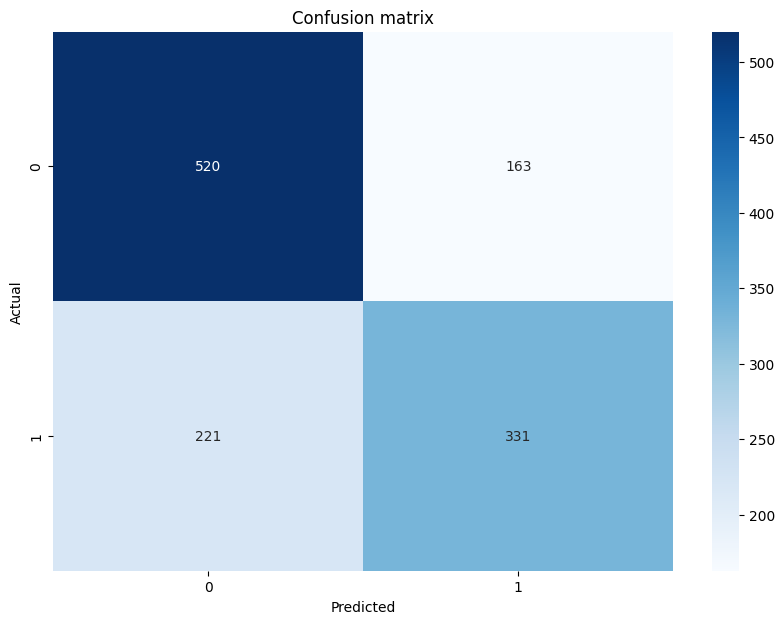

In [12]:
THRESHOLD = 0.5
y_pred_custom = np.where(y_pred_proba >= THRESHOLD, 1, 0)

conf_matrix = confusion_matrix(y_test_true, y_pred_custom)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")
plt.show()

In [13]:
# check performance of compas model
print(
    classification_report(
        y_true=y_test_true, y_pred=y_pred
    )
)


              precision    recall  f1-score   support

           0       0.70      0.76      0.73       683
           1       0.67      0.60      0.63       552

    accuracy                           0.69      1235
   macro avg       0.69      0.68      0.68      1235
weighted avg       0.69      0.69      0.69      1235



 # Fairness analysis

In [14]:
X_train["is_black"].value_counts()

is_black
1    2561
0    2376
Name: count, dtype: int64

Protected feature: is_black
selection_rate         0.504947
true_positive_rate     0.664000
true_negative_rate     0.748026
false_positive_rate    0.397376
false_negative_rate    0.556739
accuracy               0.953672
dtype: float64


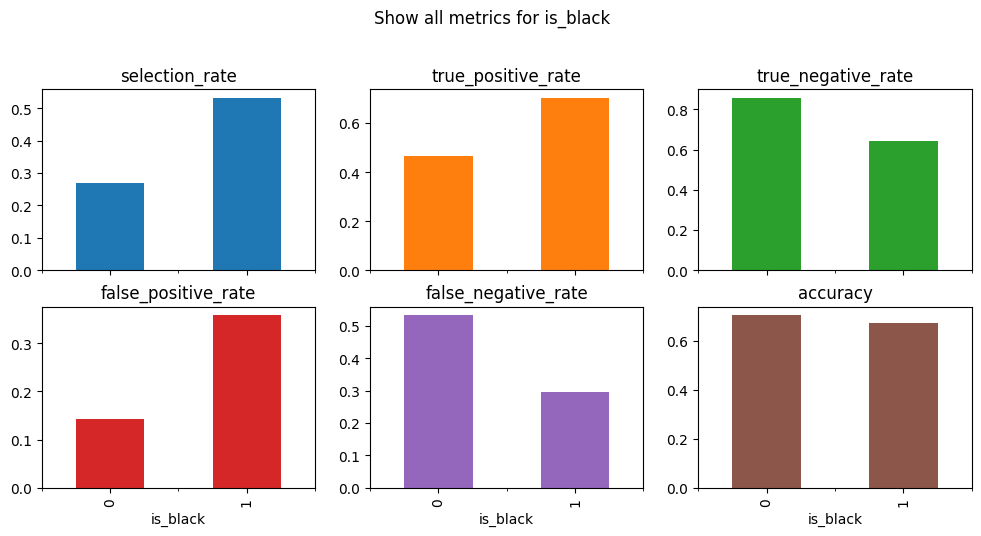

Protected feature: is_male
selection_rate         0.419165
true_positive_rate     0.523480
true_negative_rate     0.800253
false_positive_rate    0.354063
false_negative_rate    0.529682
accuracy               0.995878
dtype: float64


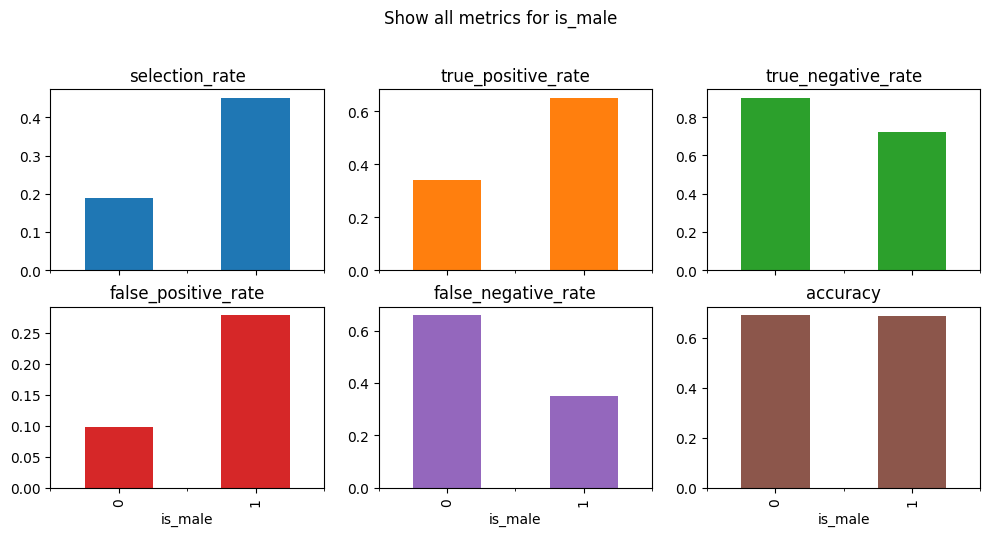

Protected feature: age
selection_rate         0.0
true_positive_rate     0.0
true_negative_rate     0.0
false_positive_rate    0.0
false_negative_rate    0.0
accuracy               0.5
dtype: float64


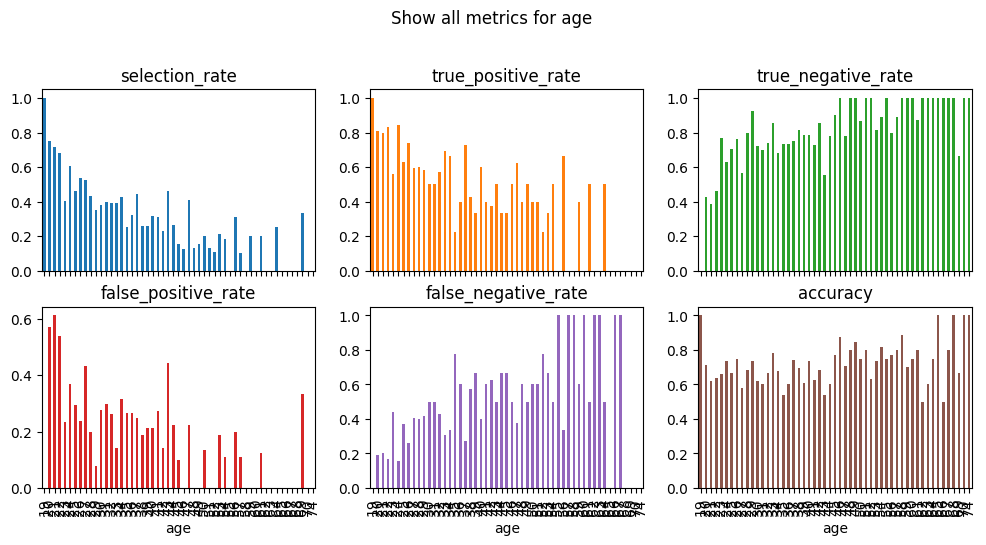

In [15]:
from fairlearn.metrics import (
    MetricFrame,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
    true_negative_rate,
    true_positive_rate,
)
from fairlearn.reductions import DemographicParity, EqualizedOdds, GridSearch
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

# Define the metric
metric = {
    "selection_rate": selection_rate,
    "true_positive_rate": true_positive_rate,
    "true_negative_rate": true_negative_rate,
    "false_positive_rate": false_positive_rate,
    "false_negative_rate": false_negative_rate,
    "accuracy": accuracy_score
}

for protected_feature in protected_features:
    print(f"Protected feature: {protected_feature}")
    # Create a MetricFrame
    metric_frame = MetricFrame(
        metrics=metric,
        y_true=y_test_true,
        y_pred=y_pred,
        sensitive_features=X_test[protected_feature]
    )

    metric_frame.by_group.plot.bar(
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        title=f"Show all metrics for {protected_feature}",
    )
    print(metric_frame.ratio())
    plt.show()

# Decision Boundary

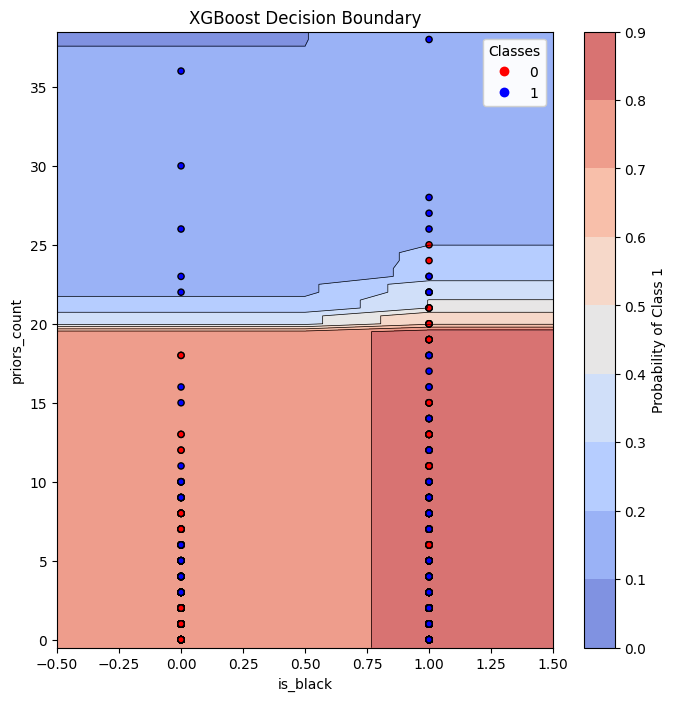

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from matplotlib.colors import ListedColormap


def plot_decision_boundary(model, X, y, feature1="is_black", feature2="priors_count", title="Decision Boundary"):
    # Extract only the relevant features for training
    X_2d = X[[feature1, feature2]]

    # Calculate means for the other features
    other_features_means = X.drop(columns=[feature1, feature2]).mean().values

    # Create a mesh grid
    h = 0.5 # step size in the mesh
    x_min, x_max = X_2d[feature1].min() - 0.5, X_2d[feature1].max() + 1
    y_min, y_max = X_2d[feature2].min() - 0.5, X_2d[feature2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Prepare the input for prediction by combining the mesh grid with the means of other features
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    mesh_input = np.hstack([mesh_points, np.tile(other_features_means, (mesh_points.shape[0], 1))])

    # Predict for each point in the mesh
    Z = model.predict_proba(mesh_input)[:, 1]
    Z = Z.reshape(xx.shape)

    # Create a plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the decision boundary
    contour = ax.contourf(xx, yy, Z, alpha=0.7, cmap='coolwarm')

    # Add contour lines
    contour_lines = ax.contour(xx, yy, Z, levels=np.arange(0, 1.1, 0.1), colors='black', linewidths=0.5)

    # Plot the actual data points
    scatter = ax.scatter(
        X_2d[feature1],
        X_2d[feature2],
        c=y,
        edgecolor="k",
        s=20,
        cmap=ListedColormap(("red", "blue")),
    )
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)

    # Add a color bar for the contour levels
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label('Probability of Class 1')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title(title)

    plt.show()

# Example usage:
# Assuming you have a pre-trained model and your data ready
plot_decision_boundary(
    model,
    X_test,
    y_test_true,
    "is_black",
    "priors_count",
    "XGBoost Decision Boundary",
)


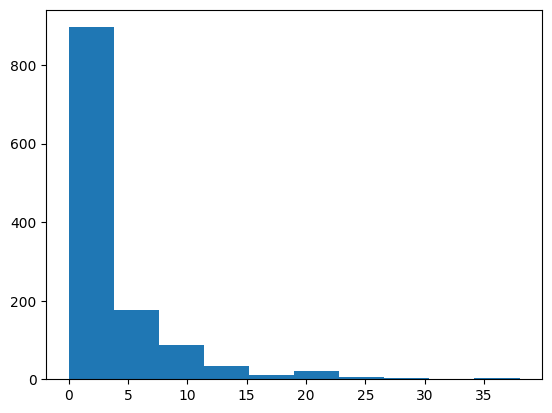

In [18]:
X_test.priors_count.hist().plot()
plt.grid(False)